In [1]:

import time
import math
import json
import pickle

import statistics

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as Data
import torch.nn.functional as F
import matplotlib
import matplotlib.pyplot as plt

from os import listdir
from os.path import join
from os.path import isfile

from itertools import combinations

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import datasets
from sklearn import svm
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score


from libsvm.svmutil import svm_problem
from libsvm.svmutil import svm_parameter
from libsvm.svmutil import svm_train
from libsvm.svmutil import svm_predict
from libsvm.svmutil import evaluations

from Function import svm_function

In [2]:
import seaborn as sns

2332


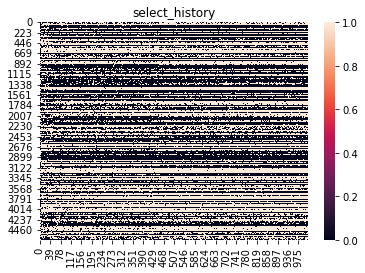

In [7]:
f = open("data/merge_data/seq_rbp_output/pse_in_one*rbp_pvalue_cutoff10-3_-log10__utest_pval005__train__x__PSO_train_s1_f5_u10_e100_t1000__PSO_train_daal4py__v230427.json")
# f = open("data/merge_data/seq_rbp_output/pse_in_one*rbp_pvalue_cutoff10-3_-log10__utest_pval005__train__x__PSO_train_s1_f5_u10_e100_t1000_a05__PSO_train_daal4py__v230427.json")
perf = json.load(f)
f.close()
selected = np.where(np.array(perf['selected_features']) == 'True', 1, 0)
print(sum(selected))

ax = plt.axes()
sns.heatmap(np.array(perf['select_history'], dtype=bool).T, ax = ax)
ax.set_title('select_history')
plt.show()

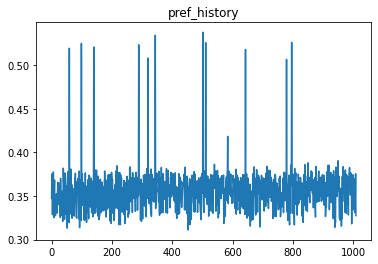

In [9]:
plt.plot(np.arange(len(perf['pref_history'])), np.array(perf['pref_history']))
plt.title("pref_history")
plt.show()

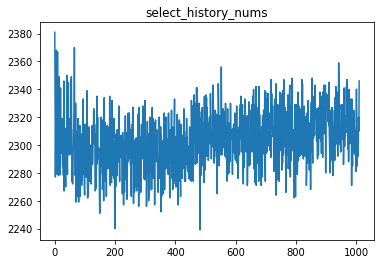

In [8]:
plt.plot(np.arange(np.array(perf['select_history'], dtype=bool).shape[0]), np.sum(np.array(perf['select_history'], dtype=bool), axis=1))
plt.title("select_history_nums")
plt.show()

<AxesSubplot:>

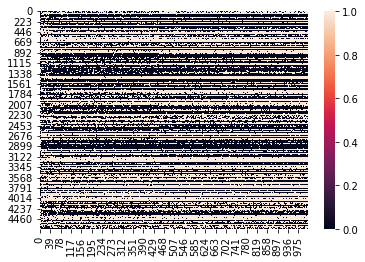

In [13]:
sns.heatmap(np.array(perf['select_history'], dtype=bool).T)

In [50]:
y = np.load("data/merge_data/seq_rbp/pse_in_one2__rbp_10-3_-log10__train__y.npy")

In [17]:
perf_list = []

In [20]:
dir_path = "data/RBP_eclip/output/"
onlyfiles = [f for f in listdir(dir_path) if isfile(join(dir_path, f))]

for file_name in onlyfiles:
    if ("hpo_svm_train__" in file_name) and ("_hasNu.json" in file_name) and not ".dvc" in file_name:
        file_name_list = file_name.split("__")
        print(file_name_list)
        file_str = file_name_list[1]
        file_hp = file_name_list[-1][:-len(".json")]
        
        print(file_str)
        f = open(dir_path + file_name)
        perf = json.load(f)
        f.close()
        num = np.load("data/RBP_eclip/train/" + file_str + ".npy").shape[1]
        perf_list.append([file_str, num, file_hp,
                          perf['avg Accy'], perf['std Accy'],
                          perf['avg Recall'], perf['std Recall'],
                          perf['avg Prec'], perf['std Prec'],
                          perf['avg Spec'], perf['std Spec'],
                          perf['avg Npv'], perf['std Npv'],
                          perf['avg F1sc'], perf['std F1sc'],
                          perf['avg AUROC'], perf['std AUROC']
                          ])

['hpo_svm_train', 'x', 'esvm_e512_p10_f10_s10_t1000_hasNu.json']
x
['hpo_svm_train', 'x', 'esvm_e512_p10_f10_s10_t10000_hasNu.json']
x
['hpo_svm_train', 'x', 'esvm_e1024_p10_f10_s10_t1000_hasNu.json']
x
['hpo_svm_train', 'x', 'esvm_e1024_p10_f10_s10_t10000_hasNu.json']
x
['hpo_svm_train', 'pseinone_rbpeclip_x', 'esvm_e512_p10_f10_s10_t1000_hasNu.json']
pseinone_rbpeclip_x
['hpo_svm_train', 'pseinone_rbpeclip_x', 'esvm_e512_p10_f10_s10_t10000_hasNu.json']
pseinone_rbpeclip_x
['hpo_svm_train', 'pseinone_rbpeclip_x', 'esvm_e1024_p10_f10_s10_t1000_hasNu.json']
pseinone_rbpeclip_x
['hpo_svm_train', 'pseinone_rbpeclip_x', 'esvm_e1024_p10_f10_s10_t10000_hasNu.json']
pseinone_rbpeclip_x
['hpo_svm_train', 'pseinone_rbpeclip_x', 'esvm_e512_p10_f10_s20_t10000_hasNu.json']
pseinone_rbpeclip_x
['hpo_svm_train', 'pseinone_rbpeclip_x', 'esvm_e512_p10_f10_s20_t1000_hasNu.json']
pseinone_rbpeclip_x
['hpo_svm_train', 'pseinone_rbpeclip_x', 'esvm_e1024_p10_f10_s20_t10000_hasNu.json']
pseinone_rbpeclip_x


In [15]:
dir_path = "data/merge_data/seq_rbp_output/"
onlyfiles = [f for f in listdir(dir_path) if isfile(join(dir_path, f))]

for file_name in onlyfiles:
    if ("hpo_svm_train__" in file_name) and ("_hasNu.json" in file_name) and not "pse" in file_name and not ".dvc" in file_name:
        file_name_list = file_name.split("__")
        print(file_name_list)
        # file_str = file_name_list[1] + "__" + file_name_list[2]
        file_str = file_name_list[1]
        file_hp = file_name_list[-1][:-len(".json")]
        
        print(file_str)
        f = open(dir_path + file_name)
        perf = json.load(f)
        f.close()
        # num = np.load("data/merge_data/seq_rbp/transcript2pse_in_one__train__x.npy").shape[1]
        num = np.load("data/merge_data/seq_rbp/" + file_str + "__train__x.npy").shape[1]
        perf_list.append([file_str, num, file_hp,
                          perf['avg Accy'], perf['std Accy'],
                          perf['avg Recall'], perf['std Recall'],
                          perf['avg Prec'], perf['std Prec'],
                          perf['avg Spec'], perf['std Spec'],
                          perf['avg Npv'], perf['std Npv'],
                          perf['avg F1sc'], perf['std F1sc'],
                          perf['avg AUROC'], perf['std AUROC']
                          ])

['hpo_svm_train', 'rbp_10-3_-log10_utest1e-4', 'esvm_e512_p10_f10_s10_t1000_hasNu.json']
rbp_10-3_-log10_utest1e-4
['hpo_svm_train', 'rbp_10-3_-log10_utest1e-5', 'esvm_e512_p10_f10_s10_t1000_hasNu.json']
rbp_10-3_-log10_utest1e-5
['hpo_svm_train', 'rbp_10-3_-log10_utest1e-5', 'esvm_e512_p10_f10_s10_t10000_hasNu.json']
rbp_10-3_-log10_utest1e-5
['hpo_svm_train', 'rbp_10-3_-log10_utest1e-5', 'esvm_e1024_p10_f10_s10_t1000_hasNu.json']
rbp_10-3_-log10_utest1e-5
['hpo_svm_train', 'rbp_10-3_-log10_utest1e-4', 'esvm_e512_p10_f10_s10_t10000_hasNu.json']
rbp_10-3_-log10_utest1e-4
['hpo_svm_train', 'rbp_10-3_-log10_utest1e-4', 'esvm_e1024_p10_f10_s10_t1000_hasNu.json']
rbp_10-3_-log10_utest1e-4
['hpo_svm_train', 'rbp_10-3_-log10_utest1e-5', 'esvm_e1024_p10_f10_s10_t10000_hasNu.json']
rbp_10-3_-log10_utest1e-5
['hpo_svm_train', 'rbp_10-3_-log10_utest1e-4', 'esvm_e1024_p10_f10_s10_t10000_hasNu.json']
rbp_10-3_-log10_utest1e-4
['hpo_svm_train', 'rbp_10-3_-log10_utest1e-5', 'esvm_e512_p10_f10_s10_t1

In [18]:
# dir_path = "data/merge_data/output/"
dir_path = "data/RBP-PWM/output/"
onlyfiles = [f for f in listdir(dir_path) if isfile(join(dir_path, f))]


for file_name in onlyfiles:
    if ("__esvm_p10_f10_s10__v230221.json" in file_name) and not ".dvc" in file_name:
        file_str = file_name[:-len("__esvm_p10_f10_s10__v230221.json")]
    # if ("__esvm_p10_f10_s10__v230118_v2.json" in file_name) and not ".dvc" in file_name:
    #     file_str = file_name[:-len("__esvm_p10_f10_s10__v230118_v2.json")]
        
        if "train__" in file_str:
            file_str = file_str.replace("train", "train_binary")
        print(file_str)
        f = open(dir_path + file_name)
        perf = json.load(f)
        f.close()
        num = np.load("data/RBP-PWM/train/" + file_str + "__x.npy").shape[1]
        perf_list.append([file_str, num,
                          perf['avg Accy'], perf['std Accy'],
                          perf['avg Recall'], perf['std Recall'],
                          perf['avg Prec'], perf['std Prec'],
                          perf['avg Spec'], perf['std Spec'],
                          perf['avg Npv'], perf['std Npv'],
                          perf['avg F1sc'], perf['std F1sc'],
                          perf['avg AUROC'], perf['std AUROC'],
                          ])

train_binary__10-4__filter
train_binary__10-3__filter
train_-log10__10-3__filter
train_-log10__10-4__filter


In [21]:
pd.DataFrame(perf_list, columns=["esvm_s10", "nums", "hp", 
                                 "avg Accy", "std Accy",
                                 "avg Recall", "std Recall",
                                 "avg Prec", "std Prec",
                                 "avg Spec", "std Spec",
                                 "avg Npv", "std Npv",
                                 "avg F1sc", "std F1sc",
                                 "avg AUROC", "std AUROC"
                                 ]).sort_values("esvm_s10").to_csv("data/RBP_eclip/output/v230426__pref.csv", index=False)

In [5]:
np.load("data/linear_features/point/benchmark/train/k234p10nor2n3_train.npy").shape

(2264, 1008)

In [3]:
f = open("data/merge_data/output/Kmer_k3__DACC_lag2__SC-PseDNC-General_all_index_svmf10p4e512.json")
perf = json.load(f)
f.close()
["file_str", 
        perf['avg Accy'], perf['std Accy'],
        perf['avg Recall'], perf['std Recall'],
        perf['avg Prec'], perf['std Prec'],
        perf['avg Spec'], perf['std Spec'],
        perf['avg F1sc'], perf['std F1sc'],
        perf['avg AUROC'], perf['std AUROC'],
        ]

['file_str',
 0.7062645551932929,
 0.02728313642700328,
 0.724779861183052,
 0.027373539164752204,
 0.9191811524505985,
 0.013461697940586836,
 0.585483870967742,
 0.0729476979210487,
 0.8102467384324458,
 0.019711847903634495,
 0.6936555352450462,
 0.04558923440965074]

In [16]:
from numpy import average


dir_path = "data/linear_features/point/benchmark/output/"
onlyfiles = [f for f in listdir(dir_path) if isfile(join(dir_path, f))]

perf_list = []

for file_name in onlyfiles:
    if "_svmf10p4e512.json" in file_name and not ".dvc" in file_name and not "train" in file_name:
        
        file_str = file_name[:-5]
        f = open(dir_path + file_name)
        perf = json.load(f)
        f.close()
        perf_list.append([file_str, np.load("data/linear_features/point/benchmark/train/" + file_name[:-18] + "_train.npy").shape[1],
                          perf['avg Accy'], perf['std Accy'],
                          perf['avg Recall'], perf['std Recall'],
                          perf['avg Prec'], perf['std Prec'],
                          perf['avg Spec'], perf['std Spec'],
                          perf['avg F1sc'], perf['std F1sc'],
                          perf['avg AUROC'], perf['std AUROC'],
                          ])
        # npv_array = []
        # for i in range(len(perf['confusion matrix'])):
        #     tn, fp, fn, tp = np.array(perf['confusion matrix'][i][1]).flatten()
        #     acc = (tn + tp) / (tn + fp + fn + tp)
        #     recall = tp / (fn + tp)
        #     prec = (tp / (fp + tp))
        #     spec = (tn / (tn + fp))
        #     npv = (tn / (tn + fn))
        #     f1sc = (2 * (tp / (fn + tp)) * (tp / (fp + tp)) / ((tp / (fn + tp)) + (tp / (fp + tp))))
        #     npv_array.append(npv)
        # print(npv_array)
        # print(sum(npv_array)/ len(npv_array), np.std(npv_array))

In [18]:
pd.DataFrame(perf_list, columns=['file name', "num", 'avg Accy', 'std Accy', 'avg Recall', 'std Recall', 'avg Prec', 'std Prec', 'avg Spec', 'std Spec', 'avg F1sc', 'std F1sc', 'avg AUROC', 'std AUROC']).sort_values('file name').to_csv(dir_path + "svmf10p4e512_pref_v2.csv", index=False)